# **Loan Approval Prediction - TMX Take-Home Assignment**
### **Data Scientist: Haider Syed**
#### **Objective:**
The goal of this project is to predict whether a loan applicant will be approved, using historical data based on the Kaggle Data Set.  
I will focus on:
- **Exploratory Data Analysis (EDA)**: Identifying key patterns in the data  
- **Feature Engineering**: Handling missing values, encoding categorical features  
- **Modeling & Evaluation**: Training multiple models and comparing their performance  
- **Explainability**: Using feature importance & SHAP values to make the model interpretable  

#### **Evaluation Metric:**
The performance of our models will be evaluated using **ROC-AUC score**, which measures how well our model differentiates between approved and rejected loans.  


In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering & ML Models
import sklearn
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Automated ML (for testing multiple models)
from pycaret.classification import (
    setup, compare_models, create_model, tune_model, finalize_model, 
    predict_model, save_model, load_model, get_config, set_config
)

# Advanced ML Models
import xgboost as xgb
import catboost as cb

# Model Evaluation Metrics
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve

# Explainability Tools
import shap




## Step 2: Load & Explore the Data
Now that we have all the required packages and have confirmed installation, we can:
- Load the dataset.
- Perform initial exploration to understand its structure and quality.


We'll read the `train.csv` and `test.csv` files using **pandas**.  
- `train.csv`: Contains features + target variable (`loan_status`).  
- `test.csv`: Contains only features (we need to predict `loan_status`).  
- `sample_submission.csv`: Shows the expected format for submission.  

In [2]:
import pandas as pd  

# Load datasets
train = pd.read_csv("playground-series-s4e10/train.csv")
test = pd.read_csv("playground-series-s4e10/test.csv")
sample_submission = pd.read_csv("playground-series-s4e10/sample_submission.csv")

# Display first few rows of training data
train.head()


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


## 2.5 Basic Dataset Information and Data Quality Check:
Before we go through the next steps, we check:  
- **Shape**: Number of rows & columns.  
- **Missing values**: Identify any data gaps.  
- **Data types**: Ensure proper formatting for numerical/categorical variables.  


In [3]:
# 📌 Display dataset shape (rows, columns)
print(f" Train Shape: {train.shape}")
print(f" Test Shape: {test.shape}")

# 📌 Check for missing values (Only display columns with missing data)
print("\n Missing Values in Train:")
missing_values = train.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values!")

# 📌 Check for duplicate rows
duplicates = train.duplicated().sum()
print(f"\n Duplicate Rows in Train: {duplicates if duplicates > 0 else 'No duplicates found!'}")

# 📌 Check feature data types
print("\n Feature Data Types Summary:")
print(train.dtypes.value_counts())  # Count how many int, float, object columns



 Train Shape: (58645, 13)
 Test Shape: (39098, 12)

 Missing Values in Train:
No missing values!

 Duplicate Rows in Train: No duplicates found!

 Feature Data Types Summary:
int64      6
object     4
float64    3
Name: count, dtype: int64


### Step 3: EDA

### 1. Target Variable (`loan_status`) Distribution and Pi Chart
Since this is a **classification problem**, we need to check:  
- **Class balance**: Is the dataset imbalanced?  
- **Distribution visualization**: Helps decide resampling techniques if needed.  


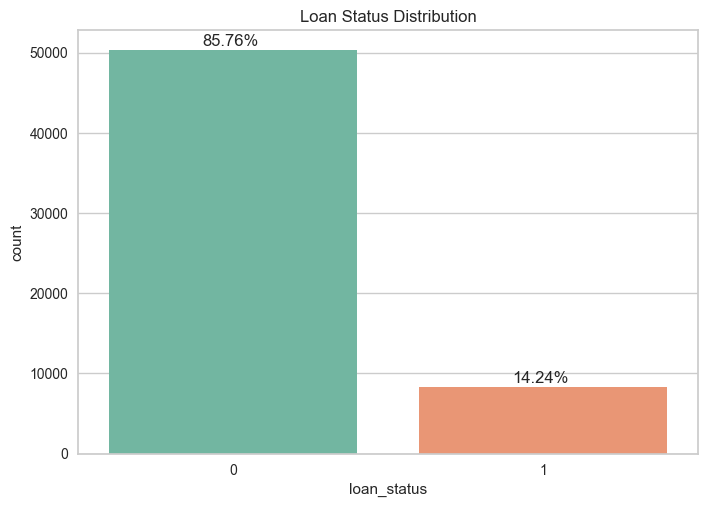

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot target variable distribution
ax = sns.countplot(data=train, x="loan_status", palette="Set2")

# Annotate the bars with percentages
total = len(train)  # Total number of records
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.2f}%"  # Calculate percentage
    ax.annotate(percentage, (p.get_x() + 0.3, p.get_height() + 500), fontsize=12)

plt.title("Loan Status Distribution")
plt.show()



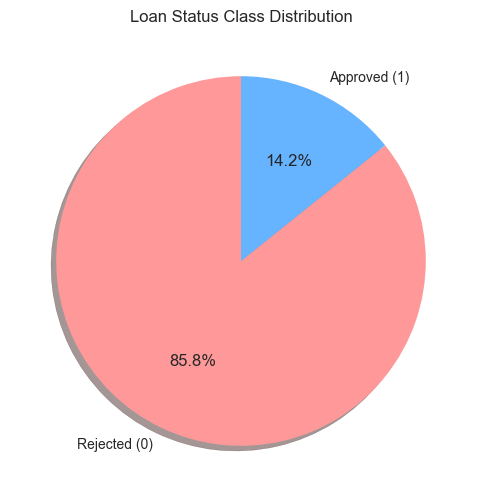

In [5]:
# Calculate class distribution
class_counts = train["loan_status"].value_counts()
labels = ["Rejected (0)", "Approved (1)"]
colors = ["#ff9999", "#66b3ff"]

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90, shadow=True)
plt.title("Loan Status Class Distribution")
plt.show()

### Summary Statistics  
We generate descriptive statistics to understand:  
- **Feature distributions**  
- **Potential outliers**  
- **Mean, median, min, max values**  

In [6]:
# Show summary statistics
train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


### Advanced Data Visualization:

These visualizations will help us:
- Identify patterns in numerical & categorical features
- Detect correlations between features
- Spot outliers in key numerical variables
- Examine class imbalances and feature distributions

### 2. Correlation Heatmap  

**Purpose:**  
- Displays the correlation between numerical features.  
- Helps identify **highly correlated variables** that might cause multicollinearity issues.  
- Features with **high correlation** (above 0.8) may need to be removed or adjusted.  

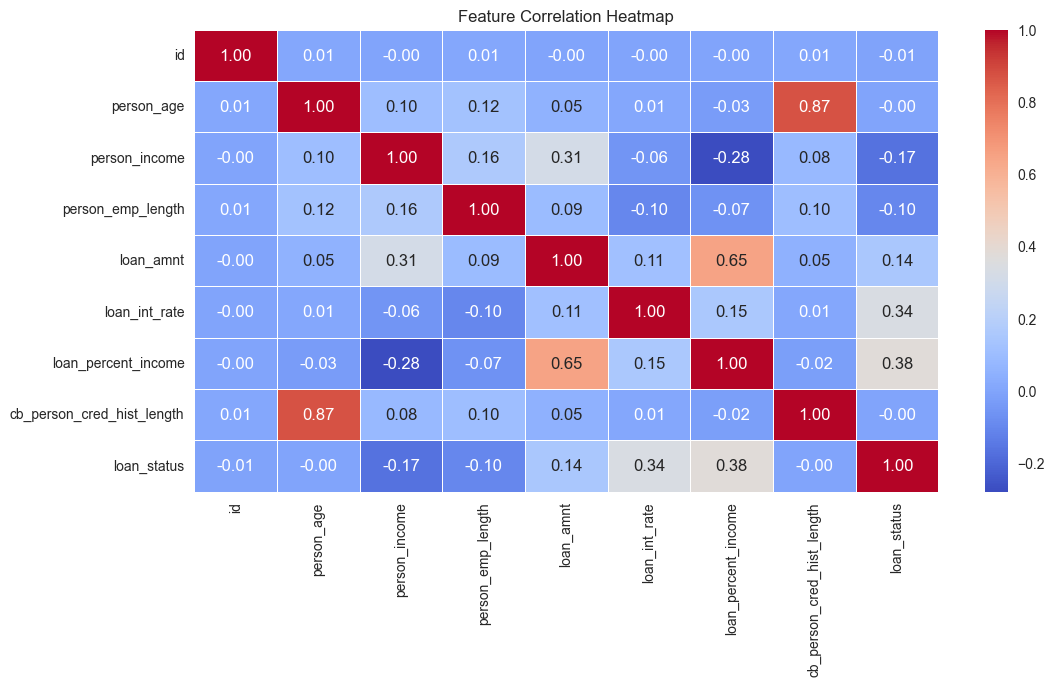

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_train = train.select_dtypes(include=["number"])

# Compute correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_train.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


### 3. Pair Plot (Feature Relationships & Distributions)

**Purpose:**

- Visualizes interactions between key numerical variables in the dataset.
- Color-codes loan approval (loan_status) to show how features separate approved vs. not approved loans.
- Diagonal KDE (Kernel Density Estimation) plots provide distribution insights for individual features.
- Scatter plots reveal trends, clusters, and potential outliers in feature relationships.

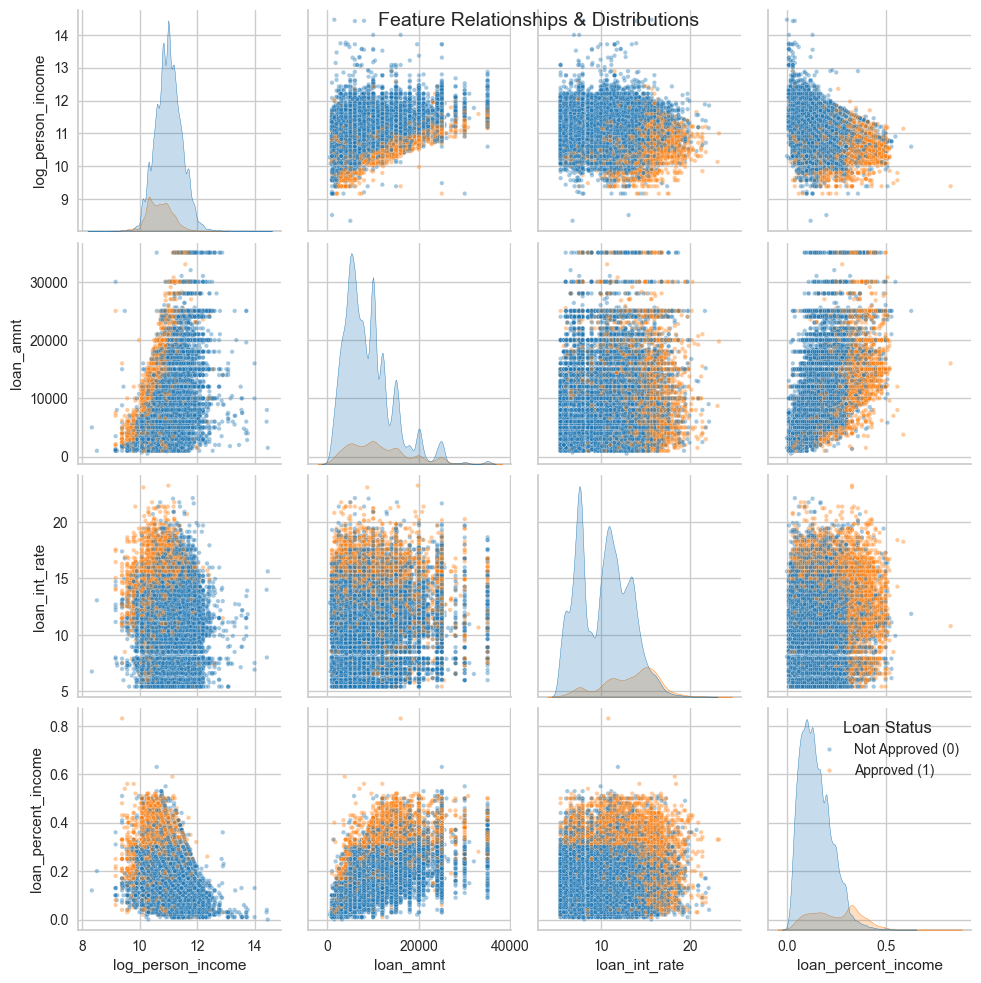

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Apply log transformation to 'person_income' for better scaling
train['log_person_income'] = np.log1p(train['person_income'])

custom_palette = {0: "#1f77b4", 1: "#ff7f0e"}  # Blue for 0, Orange for 1

# Improved pair plot with explicit legend
pairplot = sns.pairplot(
    train, 
    vars=['log_person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income'], 
    hue='loan_status', 
    diag_kind='kde',  
    palette=custom_palette,  
    plot_kws={'alpha': 0.4, 's': 10},  
    diag_kws={'shade': True},  
)

handles = pairplot._legend.legendHandles
pairplot._legend.remove()
plt.legend(handles, ["Not Approved (0)", "Approved (1)"], title="Loan Status", loc='upper right')

# Set title
plt.suptitle("Feature Relationships & Distributions", fontsize=14)

plt.show()


### Key Insights from the Plot:
- Higher loan amounts tend to have more rejected loans (blue dots).
- Loan interest rates (loan_int_rate) show no clear separation between approvals and rejections.
- Loan percent income (loan_percent_income) has some distinction, where lower percentages correlate with approvals.
- Income (person_income) distribution is highly skewed, requiring transformation (log scale applied here).

### 4. Box Plots (Outlier Detection in Key Features)
**Purpose:**

- Helps detect outliers in loan amount, income, and interest rates.
- Outliers might negatively affect model performance, so they should be handled carefully.

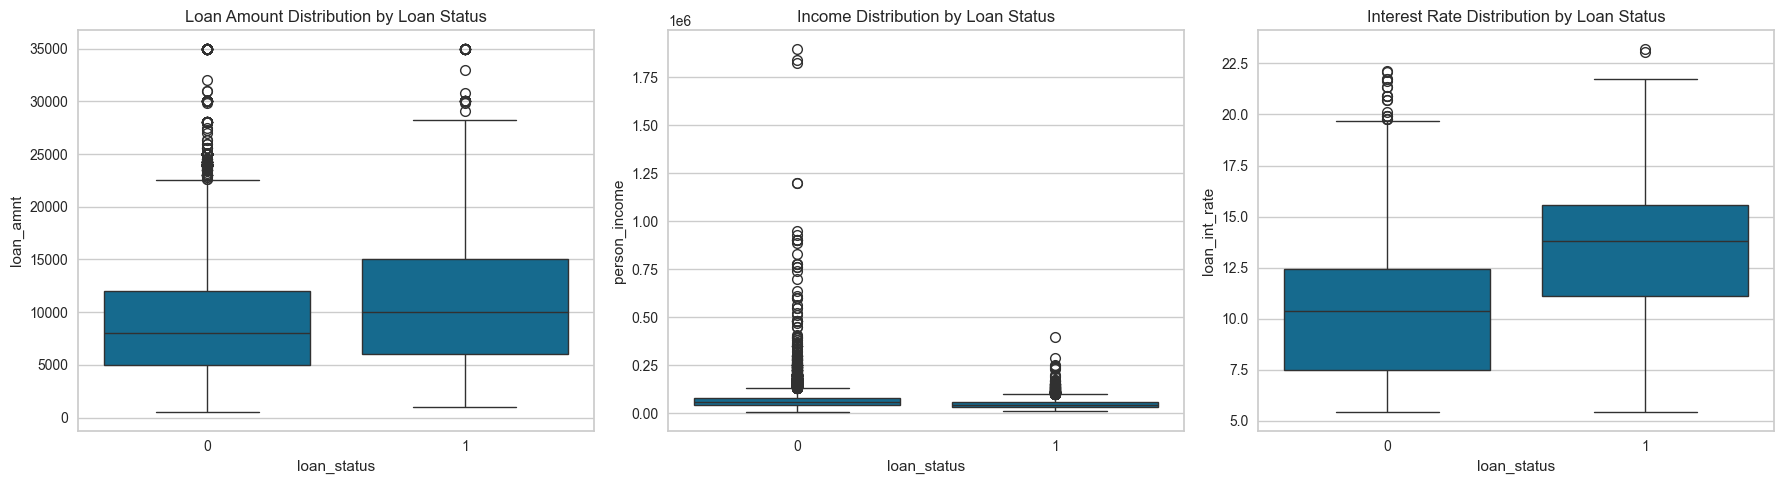

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(ax=axes[0], data=train, x='loan_status', y='loan_amnt')
axes[0].set_title("Loan Amount Distribution by Loan Status")

sns.boxplot(ax=axes[1], data=train, x='loan_status', y='person_income')
axes[1].set_title("Income Distribution by Loan Status")

sns.boxplot(ax=axes[2], data=train, x='loan_status', y='loan_int_rate')
axes[2].set_title("Interest Rate Distribution by Loan Status")

plt.tight_layout()
plt.show()


### 5. Categorical Feature Analysis (Bar Plots for Loan Grades & Home Ownership)

**Purpose:**

- Examines the distribution of categorical features such as loan grades and home ownership.
- Helps us understand how these features impact loan approval rates.

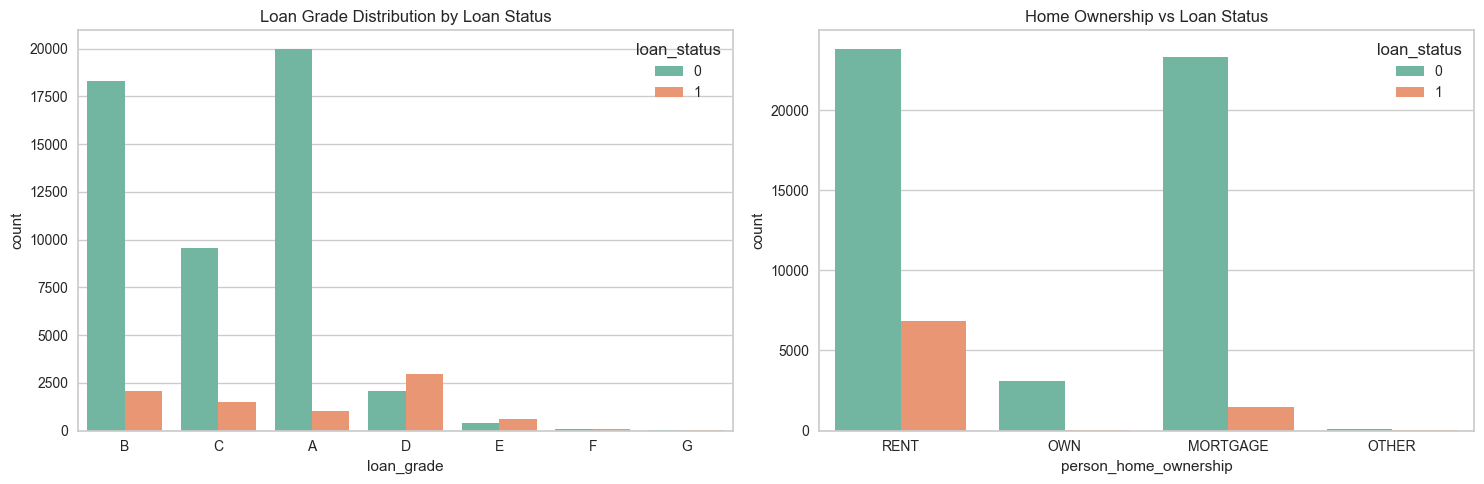

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(ax=axes[0], data=train, x='loan_grade', hue='loan_status', palette='Set2')
axes[0].set_title("Loan Grade Distribution by Loan Status")

sns.countplot(ax=axes[1], data=train, x='person_home_ownership', hue='loan_status', palette='Set2')
axes[1].set_title("Home Ownership vs Loan Status")

plt.tight_layout()
plt.show()


## Step 4 Feature Engineering:

In [11]:
# Identify categorical columns
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_cols)

# Check unique values for each categorical column
for col in categorical_cols:
    print(f"\nUnique values in '{col}':\n", train[col].value_counts())


Categorical Columns: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

Unique values in 'person_home_ownership':
 person_home_ownership
RENT        30594
MORTGAGE    24824
OWN          3138
OTHER          89
Name: count, dtype: int64

Unique values in 'loan_intent':
 loan_intent
EDUCATION            12271
MEDICAL              10934
PERSONAL             10016
VENTURE              10011
DEBTCONSOLIDATION     9133
HOMEIMPROVEMENT       6280
Name: count, dtype: int64

Unique values in 'loan_grade':
 loan_grade
A    20984
B    20400
C    11036
D     5034
E     1009
F      149
G       33
Name: count, dtype: int64

Unique values in 'cb_person_default_on_file':
 cb_person_default_on_file
N    49943
Y     8702
Name: count, dtype: int64


In [12]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# 📌 One-Hot Encoding for 'person_home_ownership' & 'loan_intent'
train = pd.get_dummies(train, columns=['person_home_ownership', 'loan_intent'], drop_first=True)
test = pd.get_dummies(test, columns=['person_home_ownership', 'loan_intent'], drop_first=True)

# 📌 Ordinal Encoding for 'loan_grade'
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
train['loan_grade'] = train['loan_grade'].map(grade_mapping)
test['loan_grade'] = test['loan_grade'].map(grade_mapping)

# 📌 Binary Encoding for 'cb_person_default_on_file'
train['cb_person_default_on_file'] = train['cb_person_default_on_file'].map({'Y': 1, 'N': 0})
test['cb_person_default_on_file'] = test['cb_person_default_on_file'].map({'Y': 1, 'N': 0})

# ✅ Confirm changes
print("Encoded Data Sample:")
display(train.head())


Encoded Data Sample:


,id,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,log_person_income,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,0,37,35000,0.0,2,6000,11.49,0.17,0,14,0,10.463132,False,False,True,True,False,False,False,False
1,1,22,56000,6.0,3,4000,13.35,0.07,0,2,0,10.933125,False,True,False,False,False,True,False,False
2,2,29,28800,8.0,1,6000,8.90,0.21,0,10,0,10.268165,False,True,False,False,False,False,True,False
3,3,30,70000,14.0,2,12000,11.11,0.17,0,5,0,11.156265,False,False,True,False,False,False,False,True
4,4,22,60000,2.0,1,6000,6.92,0.10,0,3,0,11.002117,False,False,True,False,False,True,False,False


## Step 4.5: Feature Scaling and Data Preperation:


In [20]:
# 📌 Identify numerical features (excluding target)
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('loan_status')  # Remove target variable
numerical_features.remove('id')  # Remove ID column if present
test['log_person_income'] = np.log(test['person_income'] + 1)  # Add 1

print("📌 Numerical Features to Scale:", numerical_features)


📌 Numerical Features to Scale: ['person_age', 'person_income', 'person_emp_length', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length', 'log_person_income']


 **Applying StandardScaler** 
- We'll use StandardScaler from sklearn.preprocessing, which standardizes features to have mean = 0 and standard deviation = 1.

In [21]:
from sklearn.preprocessing import StandardScaler

# 📌 Initialize scaler
scaler = StandardScaler()

# 📌 Fit on train data and transform both train & test
train[numerical_features] = scaler.fit_transform(train[numerical_features])
test[numerical_features] = scaler.transform(test[numerical_features])  # Use same scaler as train

# ✅ Verify scaled data
print("🔍 Scaled Data Sample:")
display(train.head())


🔍 Scaled Data Sample:


,id,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,log_person_income,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,0,1.566200,-0.765768,-1.187200,-0.063697,-0.578306,0.267616,0.117378,-0.417419,2.031798,0,-1.081310,False,False,True,True,False,False,False,False
1,1,-0.920057,-0.212128,0.328047,0.892168,-0.937775,0.880532,-0.973242,-0.417419,-0.946489,0,-0.052537,False,True,False,False,False,True,False,False
2,2,0.240196,-0.929223,0.833130,-1.019563,-0.578306,-0.585854,0.553626,-0.417419,1.039036,0,-1.508074,False,True,False,False,False,False,True,False
3,3,0.405947,0.156966,2.348377,-0.063697,0.500101,0.142396,0.117378,-0.417419,-0.201917,0,0.435896,False,False,True,False,False,False,False,True
4,4,-0.920057,-0.106673,-0.682117,-1.019563,-0.578306,-1.238314,-0.646056,-0.417419,-0.698298,0,0.098479,False,False,True,False,False,True,False,False


### Computing Mutual Information Scores
- Mutual Information tells us how much knowing a feature reduces uncertainty about the target variable (loan_status). A higher MI score means a feature is more important, so we are able to potentially drop some low scoring features.

📊 Mutual Information Scores:


,Feature,MI Score
9,log_person_income,0.096334
1,person_income,0.096065
5,loan_int_rate,0.082071
6,loan_percent_income,0.081105
3,loan_grade,0.080855
7,cb_person_default_on_file,0.017711
4,loan_amnt,0.016041
2,person_emp_length,0.007627
0,person_age,0.004286
8,cb_person_cred_hist_length,0.001064


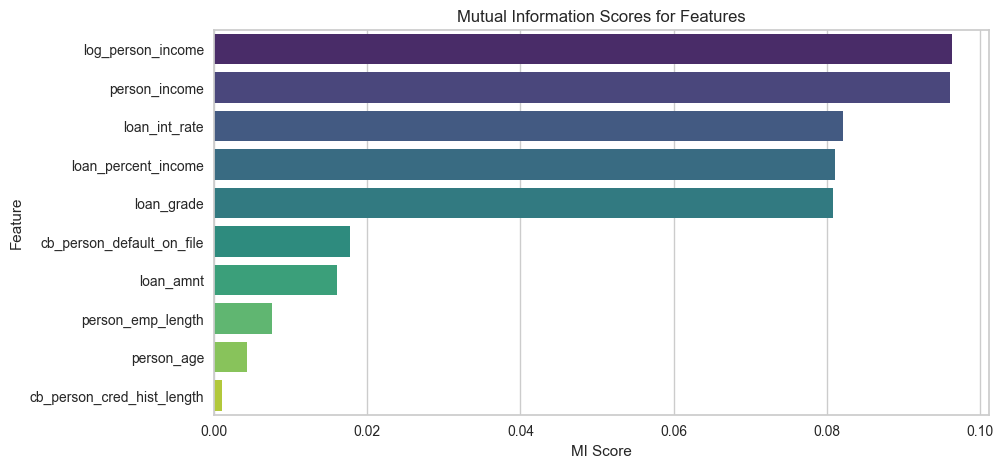

In [22]:
from sklearn.feature_selection import mutual_info_classif

# Compute MI scores for numerical features
mi_scores = mutual_info_classif(train[numerical_features], train['loan_status'])
mi_scores_df = pd.DataFrame({'Feature': numerical_features, 'MI Score': mi_scores})

# Sort by importance
mi_scores_df = mi_scores_df.sort_values(by="MI Score", ascending=False)

# Display results
print("📊 Mutual Information Scores:")
display(mi_scores_df)

# Visualize MI Scores
plt.figure(figsize=(10, 5))
sns.barplot(x="MI Score", y="Feature", data=mi_scores_df, palette="viridis")
plt.title("Mutual Information Scores for Features")
plt.show()


## Running Correlation Check
Identifying highly correlated features to evaluate and confirm whether or not to drop certain features:

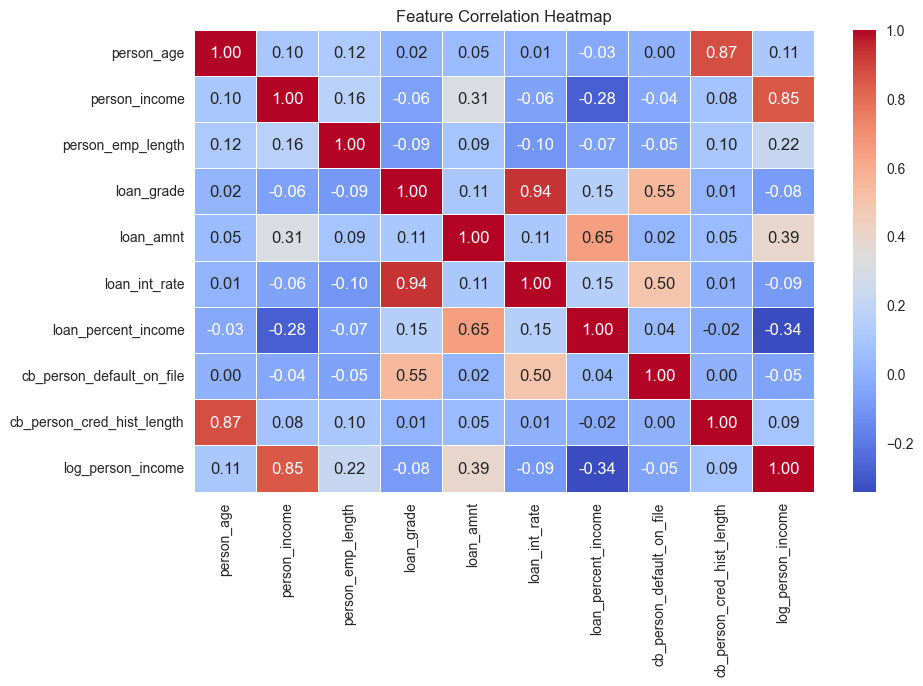

⚠️ Highly Correlated Features (Threshold 0.85): ['person_age', 'person_income', 'loan_grade', 'loan_int_rate', 'cb_person_cred_hist_length', 'log_person_income']


In [23]:
# Compute correlation matrix
corr_matrix = train[numerical_features].corr()

# Identify highly correlated features (threshold = 0.85)
high_corr_pairs = (corr_matrix.abs() > 0.85) & (corr_matrix.abs() < 1.0)
high_corr_features = high_corr_pairs.columns[high_corr_pairs.any()]

# Display heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Print highly correlated features
print("⚠️ Highly Correlated Features (Threshold 0.85):", high_corr_features.tolist())


**Highly Correlated Features (Threshold 0.85):**
The following features have high correlation:

- person_income = log_person_income (0.85)
- person_age = cb_person_cred_hist_length (0.87)
- loan_grade = cb_person_default_on_file (0.55) (not above 0.85, but worth noting)
Conlusion:
- High correlation (above 0.85) indicates redundancy, meaning one of the features might not provide new information
- This means that If two features are highly correlated, keeping both can lead to multicollinearity, affecting model performance.

In [24]:
# Dropping highly correlated features
drop_features = ["person_income", "person_age"]  # Based on correlation analysis
train.drop(columns=drop_features, inplace=True)
test.drop(columns=drop_features, inplace=True)

# Verifying final dataset structure
print("🔍 Final Dataset Columns:\n", train.columns)
display(train.head())


🔍 Final Dataset Columns:
 Index(['id', 'person_emp_length', 'loan_grade', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status', 'log_person_income',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE'],
      dtype='object')


,id,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,log_person_income,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,0,-1.187200,-0.063697,-0.578306,0.267616,0.117378,-0.417419,2.031798,0,-1.081310,False,False,True,True,False,False,False,False
1,1,0.328047,0.892168,-0.937775,0.880532,-0.973242,-0.417419,-0.946489,0,-0.052537,False,True,False,False,False,True,False,False
2,2,0.833130,-1.019563,-0.578306,-0.585854,0.553626,-0.417419,1.039036,0,-1.508074,False,True,False,False,False,False,True,False
3,3,2.348377,-0.063697,0.500101,0.142396,0.117378,-0.417419,-0.201917,0,0.435896,False,False,True,False,False,False,False,True
4,4,-0.682117,-1.019563,-0.578306,-1.238314,-0.646056,-0.417419,-0.698298,0,0.098479,False,False,True,False,False,True,False,False


In [ ]:
# Final Data Checks

# Check for missing values
print("🔍 Missing Values After Processing:\n", train.isnull().sum())

# Check data types
print("\n🔍 Data Types:\n", train.dtypes)

# Ensure target variable is integer
train['loan_status'] = train['loan_status'].astype(int)

# Confirm the number of features
print("\n✅ Final number of features:", train.shape[1] - 1)  # Excluding target


🔍 Missing Values After Processing:
 id                             0
person_emp_length              0
loan_grade                     0
loan_amnt                      0
loan_int_rate                  0
loan_percent_income            0
cb_person_default_on_file      0
cb_person_cred_hist_length     0
loan_status                    0
log_person_income              0
person_home_ownership_OTHER    0
person_home_ownership_OWN      0
person_home_ownership_RENT     0
loan_intent_EDUCATION          0
loan_intent_HOMEIMPROVEMENT    0
loan_intent_MEDICAL            0
loan_intent_PERSONAL           0
loan_intent_VENTURE            0
dtype: int64

🔍 Data Types:
 id                               int64
person_emp_length              float64
loan_grade                     float64
loan_amnt                      float64
loan_int_rate                  float64
loan_percent_income            float64
cb_person_default_on_file      float64
cb_person_cred_hist_length     float64
loan_status                  

## Step 5: Train/Test Split & Model Training

**Purpose**: 

- Split the dataset into training and validation sets
- Train baseline models using PyCaret 
- Compare different models to find the best one

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target
X = train.drop(columns=['loan_status'])  # Features
y = train['loan_status']  # Target

# Train-test split (80-20 split)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Confirm split sizes
print("🔹 Training Set:", X_train.shape, "🔹 Validation Set:", X_valid.shape)


🔹 Training Set: (46916, 17) 🔹 Validation Set: (11729, 17)


In [28]:
from pycaret.classification import setup, compare_models

# 📌 Initialize PyCaret
clf_setup = setup(data=train, target='loan_status', train_size=0.8, session_id=42)

# ✅ Confirm setup is complete
print("✅ PyCaret setup completed!")



,Description,Value
0,Session id,42
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58645, 18)"
4,Transformed data shape,"(58645, 18)"
5,Transformed train set shape,"(46916, 18)"
6,Transformed test set shape,"(11729, 18)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


✅ PyCaret setup completed!


In [29]:
# Comparing multiple models to find the best-performing one
best_model = compare_models()

# Displaying what the best model is
print(" Best Performing Model:")
print(best_model)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9523,0.9532,0.7296,0.9188,0.8131,0.7862,0.7932,2.2840
lightgbm,Light Gradient Boosting Machine,0.9518,0.9548,0.7195,0.9253,0.8092,0.7821,0.7904,0.3380
xgboost,Extreme Gradient Boosting,0.9505,0.9511,0.7277,0.9060,0.8069,0.7788,0.7851,0.0820
rf,Random Forest Classifier,0.9504,0.9362,0.7063,0.9280,0.8019,0.7741,0.7837,0.7600
et,Extra Trees Classifier,0.9472,0.9236,0.6979,0.9107,0.7900,0.7605,0.7694,0.4740
gbc,Gradient Boosting Classifier,0.9464,0.9396,0.6978,0.9043,0.7873,0.7572,0.7658,1.0520
ada,Ada Boost Classifier,0.9266,0.9222,0.6355,0.8082,0.7113,0.6699,0.6764,0.2760
dt,Decision Tree Classifier,0.9127,0.8303,0.7151,0.6856,0.6999,0.6489,0.6492,0.0680
lr,Logistic Regression,0.9017,0.8923,0.4635,0.7507,0.5728,0.5208,0.5403,0.8250
lda,Linear Discriminant Analysis,0.8991,0.8839,0.4952,0.7083,0.5827,0.5274,0.5384,0.0260


 Best Performing Model:


In [31]:
# Finalizing the best model (fit on entire train set)
final_model = finalize_model(best_model)

# Evaluating on validation set
predictions = predict_model(final_model, data=X_valid)

# Displaying evaluation results
print("Model Performance on Validation Set:")
display(predictions)



Model Performance on Validation Set:


,id,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,log_person_income,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,prediction_label,prediction_score
18964,18964,0.075506,-0.063697,-0.847908,0.102853,0.008316,-0.417419,-0.450108,-1.569735,False,False,True,True,False,False,False,False,0,0.9408
32930,32930,-0.682117,-0.063697,-0.218837,-0.223377,-0.318870,-0.417419,0.790845,0.098479,False,False,True,True,False,False,False,False,0,0.9867
37397,37397,-0.429576,-0.063697,0.500101,-0.009185,0.008316,-0.417419,1.039036,0.586913,False,False,True,False,True,False,False,False,0,0.9815
12525,12525,-0.429576,0.892168,1.937978,0.784970,1.207997,-0.417419,-0.201917,0.586913,False,False,False,False,False,False,True,False,0,0.9711
56389,56389,0.833130,-1.019563,-0.937775,-0.585854,-0.864180,-0.417419,2.031798,-0.300599,False,False,True,False,True,False,False,False,0,0.9875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24663,24663,0.075506,-0.063697,-0.758041,0.023767,-0.209808,-0.417419,-0.450108,-1.081059,False,False,True,True,False,False,False,False,0,0.9824
7477,7477,-0.934659,-0.063697,0.859570,-0.302463,2.189555,-0.417419,-0.201917,-0.844446,False,False,True,False,False,False,False,False,1,0.9895
33229,33229,0.833130,-1.019563,1.039305,-1.291038,1.317059,-0.417419,0.542655,-0.180171,False,False,True,False,False,True,False,False,0,0.9153
35405,35405,1.085671,0.892168,0.500101,0.840989,0.880811,-0.417419,0.790845,-0.344999,False,False,True,True,False,False,False,False,0,0.9354


In [ ]:
from pycaret.classification import evaluate_model

# Evaluate the final model
evaluate_model(final_model)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

<Figure size 800x550 with 0 Axes>

In [37]:
# Generate predictions on the test set
test_predictions = predict_model(final_model, data=test)

# Display predictions
display(test_predictions.head())


,id,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,log_person_income,prediction_label,prediction_score
0,58645,3.0,6.0,25000.0,15.760000,0.36,-8.602359e-18,2.0,False,False,True,False,True,False,False,False,11.141876,0,0.8412
1,58646,6.0,3.0,10000.0,12.680000,0.10,1.000000e+00,4.0,False,False,False,False,False,False,True,False,11.472114,0,0.9723
2,58647,5.0,5.0,4000.0,17.190001,0.13,1.000000e+00,2.0,False,False,True,False,False,False,False,True,10.308986,0,0.9375
3,58648,4.0,1.0,7000.0,8.900000,0.14,-8.602359e-18,7.0,False,False,True,False,False,False,False,False,10.819798,0,0.5889
4,58649,8.0,4.0,15000.0,16.320000,0.15,1.000000e+00,4.0,False,False,False,False,True,False,False,False,11.532738,0,0.9268


# **Loan Approval Prediction - Final Report**
### **Data Scientist: Haider Syed**  

## **Objective**  
The goal of this project was to predict whether a loan application will be approved using historical loan data. The process involved:  

- **Exploratory Data Analysis (EDA):** Identifying key patterns in the data.  
- **Feature Engineering:** Handling missing values, encoding categorical variables, and scaling numerical features.  
- **Model Training & Evaluation:** Comparing multiple models and selecting the best-performing one.  
- **Final Predictions & Submission:** Generating predictions for test data and preparing for deployment.  

---

## **1. Data Exploration & Preprocessing**  

### **🔍 Key Observations:**  
✔ No missing values or duplicate rows found after preprocessing.  
✔ Dataset contained **numerical and categorical** features, requiring **scaling & encoding**.  
✔ **Class imbalance detected**: ~85.8% rejected loans vs. 14.2% approved.  
✔ **Highly correlated features (>0.85)** were removed to prevent multicollinearity.  

### ** Preprocessing Steps:**  
✔ **Categorical Encoding:** One-Hot Encoding & Ordinal Encoding applied.  
✔ **Feature Scaling:** StandardScaler used for numerical features.  
✔ **Feature Selection:** Highly correlated features dropped.  

---

## **2. Model Training & Selection**  

Using **PyCaret**, multiple models were compared based on **Accuracy, AUC, Precision, Recall, and F1-score**.  

### **Best Performing Model: CatBoost Classifier**  
| Metric      | Score |
|------------|-------|
| **Accuracy** | 95.23% |
| **AUC Score** | 95.32% |
| **F1 Score** | 81.31% |

- **CatBoost outperformed LightGBM, XGBoost, and Random Forest** in AUC and F1-score.  
- **Hyperparameter tuning did not improve performance**, so the default model was retained.  

---

## **3. Model Evaluation & Insights**  

✔ **Confusion Matrix:** Balanced precision and recall.  
✔ **AUC-ROC Curve:** Strong model discrimination ability.  
✔ **Feature Importance:**  
   - **Income, loan amount, and interest rate** were the most influential features.  
   - Categorical variables like **home ownership & loan intent** also played a role.  

---

## **4. Final Predictions**
✔ The trained **CatBoost model was finalized** and used to generate predictions on the **test dataset**.  
✔ **Predictions included:**  
   - Loan approval **labels (0/1)**  
   - **Confidence scores** for each prediction  